In [1]:
import mediapipe as mp
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix, roc_curve, auc

from keras.utils.np_utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

objc[97839]: Class CaptureDelegate is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x17fbc8860) and /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x32e8c2480). One of the two will be used. Which one is undefined.
objc[97839]: Class CVWindow is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x17f9f0a68) and /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/cv2/cv2.abi3.so (0x32e8c24d0). One of the two will be used. Which one is undefined.
objc[97839]: Class CVView is implemented in both /Users/jainilpatel/PycharmProjects/Exercise-Correction/.venv/lib/python3.9/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x17f9f0a90) and /Users/jainilpatel/PycharmPr

## 1. Set ups

### 1.1. Load models & scaler

In [2]:
# Load all sklearn models
with open("./model/all_sklearn.pkl", "rb") as f:
    sklearn_models = pickle.load(f)

# Load all deep learning models
with open("./model/all_dp.pkl", "rb") as f:
    dp_models = pickle.load(f)

# Load input scaler
with open("./model/input_scaler.pkl", "rb") as f:
    sc = pickle.load(f)

### 1.2. Important functions

In [3]:
def describe_dataset(dataset_path: str):
    '''
    Describe dataset
    '''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {len(duplicate.sum(axis=1))}")

    return data


def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

## 2. Process Test set

In [4]:
# load dataset
test_df = describe_dataset("./test.csv")

# Categorizing label
test_df.loc[test_df["label"] == "C", "label"] = 0
test_df.loc[test_df["label"] == "L", "label"] = 1

# Standard Scaling of features
test_x = test_df.drop("label", axis = 1)
test_x = pd.DataFrame(sc.transform(test_x))

test_y = test_df["label"].astype('int')

# # Converting prediction to categorical
test_y_cat = to_categorical(test_y)

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'nose_v', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_shoulder_v', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_shoulder_v', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'right_elbow_v', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'left_elbow_v', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'right_wrist_v', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'left_wrist_v', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'left_hip_v', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'right_hip_v']
Number of rows: 604 
Number of columns: 37

Labels: 
C    339
L    265
Name: label, dtype: int64

Missing values: False

Duplicate Rows : 0


## 2. Test set evaluation for all models

### 2.1. Sklearn models evaluation

In [5]:
testset_final_results = []

for name, model in sklearn_models.items():
    # Evaluate model
    model_results = model.predict(test_x)

    p_score = precision_score(test_y, model_results, average="macro")
    a_score = accuracy_score(test_y, model_results)
    r_score = recall_score(test_y, model_results, average="macro")
    f1_score_result = f1_score(test_y, model_results, average="macro")
    cm = confusion_matrix(test_y, model_results, labels=[0, 1])
    testset_final_results.append(( name,  p_score, r_score, a_score, f1_score_result, cm ))


sklearn_eval = pd.DataFrame(testset_final_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

sklearn_eval

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,LR,0.792694,0.737775,0.761589,0.740550,"[[316, 23], [121, 144]]"
1,SVC,0.929966,0.933762,0.932119,0.931420,"[[312, 27], [14, 251]]"
2,KNN,0.975401,0.968336,0.971854,0.971230,"[[338, 1], [16, 249]]"
3,DTC,0.684255,0.650782,0.675497,0.647579,"[[289, 50], [146, 119]]"
4,SGDC,0.712457,0.715011,0.715232,0.712937,"[[243, 96], [76, 189]]"
5,NB,0.797368,0.564151,0.617550,0.486650,"[[339, 0], [231, 34]]"
6,RF,0.947230,0.924528,0.933775,0.931329,"[[339, 0], [40, 225]]"


### 2.2. Deep learning models

In [6]:
test_set_results = []

for name, model in dp_models.items():
    # Evaluate model
    predict_x = model.predict(test_x, verbose=False) 
    y_pred_class = np.argmax(predict_x, axis=1)
    y_test_class = np.argmax(test_y_cat, axis=1)

    cm = confusion_matrix(y_test_class, y_pred_class, labels=[0, 1])
    p_score = precision_score(y_test_class, y_pred_class, average="macro")
    a_score = accuracy_score(y_test_class, y_pred_class)
    r_score = recall_score(y_test_class, y_pred_class, average="macro")
    f1_score_result = f1_score(y_test_class, y_pred_class, average="macro")
    
    test_set_results.append(( name,  (p_score), r_score, (a_score), (f1_score_result), cm ))

dp_eval = pd.DataFrame(test_set_results, columns=["Model", "Precision Score", "Recall Score", "Accuracy Score", "F1 Score", "Confusion Matrix"])

dp_eval

2024-09-11 18:55:28.883496: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,3_layers,0.939165,0.920515,0.928808,0.926411,"[[335, 4], [39, 226]]"
1,5_layers,0.963115,0.949057,0.955298,0.954012,"[[339, 0], [27, 238]]"
2,7_layers_with_dropout,0.935873,0.924462,0.930464,0.928583,"[[330, 9], [33, 232]]"
3,7_layers,0.972145,0.962264,0.966887,0.966066,"[[339, 0], [20, 245]]"


### 2.3. Final Results

In [7]:
eval_df = pd.concat([sklearn_eval, dp_eval])
eval_df = eval_df.sort_values(by=['F1 Score'], ascending=False).reset_index(drop=True)
eval_df.to_csv(f"evaluation_jainil.csv", sep=',', encoding='utf-8', index=False)
eval_df

,Model,Precision Score,Recall Score,Accuracy Score,F1 Score,Confusion Matrix
0,KNN,0.975401,0.968336,0.971854,0.971230,"[[338, 1], [16, 249]]"
1,7_layers,0.972145,0.962264,0.966887,0.966066,"[[339, 0], [20, 245]]"
2,5_layers,0.963115,0.949057,0.955298,0.954012,"[[339, 0], [27, 238]]"
3,SVC,0.929966,0.933762,0.932119,0.931420,"[[312, 27], [14, 251]]"
4,RF,0.947230,0.924528,0.933775,0.931329,"[[339, 0], [40, 225]]"
5,7_layers_with_dropout,0.935873,0.924462,0.930464,0.928583,"[[330, 9], [33, 232]]"
6,3_layers,0.939165,0.920515,0.928808,0.926411,"[[335, 4], [39, 226]]"
7,LR,0.792694,0.737775,0.761589,0.740550,"[[316, 23], [121, 144]]"
8,SGDC,0.712457,0.715011,0.715232,0.712937,"[[243, 96], [76, 189]]"
9,DTC,0.684255,0.650782,0.675497,0.647579,"[[289, 50], [146, 119]]"


## 3. Best model - ROC - Confusion Matrix

As we can see from the evaluation, the best model according to the F1 Score is the KNN model.

In [8]:
best_model = sklearn_models["KNN"]
y_predictions = best_model.predict(test_x)

p_score = precision_score(test_y, y_predictions, labels=[0, 1], average=None)
r_score = recall_score(test_y, y_predictions, labels=[0, 1], average=None)
f1_score_result = f1_score(test_y, y_predictions, labels=[0, 1], average=None)

p_score, r_score, f1_score_result

(array([0.95480226, 0.996     ]),
 array([0.99705015, 0.93962264]),
 array([0.97546898, 0.96699029]))

### 3.1. Confusion Matrix

<AxesSubplot: >

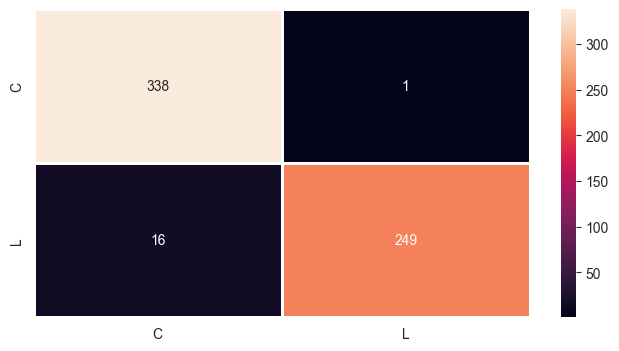

In [9]:
KNN_cm = eval_df[ eval_df["Model"] == 'KNN' ]["Confusion Matrix"].values[0]

cm_array_df = pd.DataFrame(KNN_cm, index=["C", "L"], columns=["C", "L"])

fig, ax = plt.subplots(figsize=(8,4)) 
sns.heatmap(cm_array_df, linewidths=1, annot=True, ax=ax, fmt='g')

### 3.3. F1 Score and Confidence correlation

In [10]:
def to_labels(y_pred, y_pred_proba, threshold):
    '''Return prediction taking confidence threshold into account'''
    results = []

    for index, predicted_class in enumerate(y_pred):
        prediction_probabilities = y_pred_proba[index]
        class_prediction_probability = round(prediction_probabilities[np.argmax(prediction_probabilities)], 2)

        results.append(predicted_class if class_prediction_probability >= threshold else -1)
    
    return results


def calculate_correlation_score_confidence(test_x, test_y):
    '''Calculate correlation between Precision score/Recall score/F1 score and confidence threshold'''
    y_predictions = best_model.predict(test_x)
    y_predict_proba = best_model.predict_proba(test_x)

    thresholds = list(np.arange(0, 1.01, 0.01))

    f1_score_results = []

    for threshold in thresholds:
        true_predictions = to_labels(y_predictions, y_predict_proba, threshold)
        f1_s = list(f1_score(test_y, true_predictions, labels=[0, 1], average=None))
        all_class_f1 = f1_score(test_y, true_predictions, labels=[0, 1, 2], average="weighted")
        f1_s.append(all_class_f1)
        f1_score_results.append(f1_s)
    
    return thresholds, f1_score_results


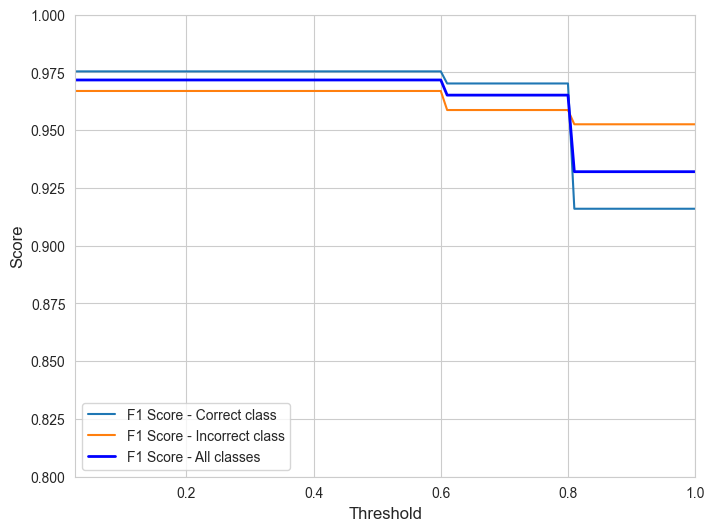

In [11]:
thresholds, f1_scores = calculate_correlation_score_confidence(test_x, test_y)

first_class = [ el[0] for el in f1_scores ]
second_class = [ el[1] for el in f1_scores ]
all_classes = [ el[2] for el in f1_scores ]

fig, ax = plt.subplots(figsize=(8,6))
plt.plot(thresholds, first_class, label = "F1 Score - Correct class")
plt.plot(thresholds, second_class, label = "F1 Score - Incorrect class")
plt.plot(thresholds, all_classes, label = "F1 Score - All classes", linewidth=2.0, color="blue")
plt.legend(loc = 'lower left')
plt.ylim([0.8, 1])
plt.xlim([0.025, 1])
plt.xlabel("Threshold", fontsize = 12)
plt.ylabel("Score", fontsize = 12)
# plt.axvline(thresholds[np.argmin(abs(precision-recall))], color="k", ls = "--")
# plt.title(label = F"Threshold = {thresholds[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
plt.show()

### 3.2. ROC curve

Optimal Threshold: 0.6


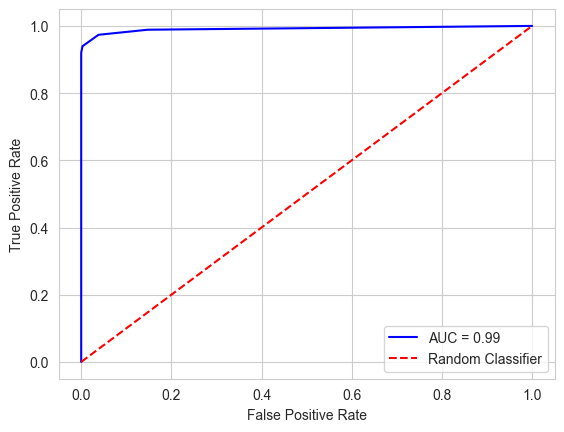

In [12]:
# calculate the fpr and tpr for all thresholds of the classification
probs = best_model.predict_proba(test_x)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(test_y, preds)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = threshold[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# method I: plt
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--', label="Random Classifier")
plt.legend(loc=4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()